In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
pip install vaderSentiment


                                              0.0/126.0 kB ? eta -:--:--
     ---------------------------------------- 126.0/126.0 kB ? eta 0:00:00


In [ ]:
import pandas as pd


attendees = pd.read_csv(r"C:\Users\kebab\OneDrive\Documents\GitHub\A2-SMNA-Group-34\datasets\attendees.csv")
attendees['Name_lower'] = attendees['Name'].str.lower()

# Load YouTube 
df = pd.read_csv(r"C:\Users\kebab\OneDrive\Documents\GitHub\A2-SMNA-Group-34\datasets\processed\youtube_comments_processed.csv")
df['text'] = df['text'].astype(str)

# Detect celebrity
celeb_list = attendees['Name_lower'].unique().tolist()

def detect_mentions(text):
    return [celeb for celeb in celeb_list if celeb in text.lower()]

df['mentioned_celebs'] = df['text'].apply(detect_mentions)
df_exploded = df.explode('mentioned_celebs').dropna(subset=['mentioned_celebs'])

# mentions per year
mention_counts = (
    df_exploded
    .groupby(['year', 'mentioned_celebs'])
    .size()
    .reset_index(name='mentions')
)

# Ensure all years 2021–2025 are included in the result
all_years = pd.DataFrame({'year': range(2021, 2026)})
top_5_per_year = (
    mention_counts
    .sort_values(['year', 'mentions'], ascending=[True, False])
    .groupby('year')
    .head(5)
)

#  back proper casing
name_map = attendees.drop_duplicates(subset='Name_lower')[['Name_lower', 'Name']]
top_5_per_year = top_5_per_year.merge(name_map, left_on='mentioned_celebs', right_on='Name_lower', how='left')


top_5_per_year = top_5_per_year[['year', 'Name', 'mentions']]
top_5_per_year = top_5_per_year.rename(columns={'Name': 'Celebrity'}).sort_values(['year', 'mentions'], ascending=[True, False])


print(top_5_per_year)


    year      Celebrity  mentions
0   2022        Rihanna       237
1   2022           Iman       189
2   2022          Ciara       185
3   2022           Rosé       133
4   2022          Lizzo        92
5   2023        Rihanna       244
6   2023           Rosé       109
7   2023        Zendaya        68
8   2023          Lizzo        28
9   2023        Shakira        16
10  2024        Zendaya       403
11  2024          Lizzo        85
12  2024          Ciara        61
13  2024        Shakira        57
14  2024        Rihanna        29
15  2025        Zendaya       259
16  2025        Rihanna       153
17  2025           Rosé        66
18  2025        Shakira        63
19  2025  Teyana Taylor        49


In [28]:
print(df['year'].value_counts().sort_index())


2022    29145
2023     8016
2024    13295
2025    21620
Name: year, dtype: int64


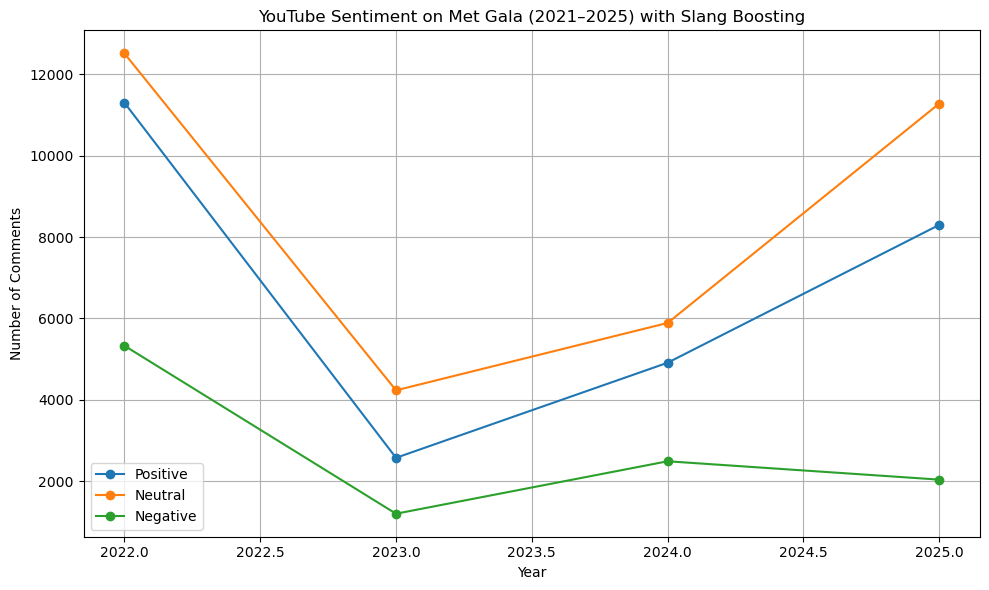

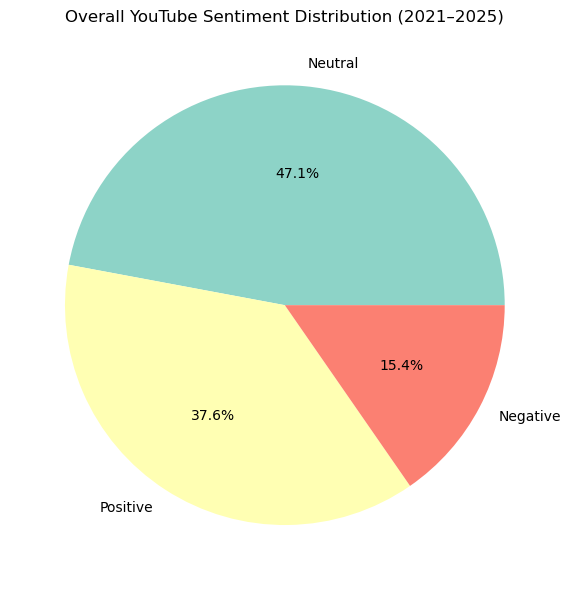

    Year      Celebrity  Mentions  Avg Sentiment  \
15  2025        Zendaya       259          0.255   
16  2025        Rihanna       146          0.134   
17  2025           Rosé        64          0.167   
18  2025        Shakira        61          0.105   
19  2025  Teyana Taylor        49          0.209   

                                   Top Positive Quote  \
15  spoken conect scream well deep perhap everi qu...   
16  thing memor specif stun babi worst bodi pliabl...   
17                      jenni love best rosé els lisa   
18                              fit best shakira lowk   
19  hater greatest teyana taylor mona ball turner-...   

                                   Top Negative Quote  
15  ridicul taylor complet mona problem amaz creat...  
16  thing neither she someon stun babi own promot ...  
17  jenni there' celebr stealer scene come rosé us...  
18                               outfit shakira worst  
19  teyana taylor alway masculin disrespect rude h...  


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer


modern_positive_slang = {
    'slay': 3.0, 'fire': 3.0, 'lit': 2.5, 'queen': 2.5, 'iconic': 2.7, 'goals': 2.5, 'stan': 3.0,
    'vibe': 1.5, 'periodt': 2.5, 'glowing': 2.0, 'obsessed': 2.5, "chef's kiss": 3.0,
    'serve': 2.5, 'ate': 3.0, 'baddie': 2.5, 'snatched': 2.5, 'yas': 2.5, 'slaps': 2.0,
    'bop': 2.0, 'glow up': 2.5, 'goated': 3.0, 'wig': 2.5, 'flex': 1.5, 'lowkey': 0.5,
    'highkey': 1.5, 'drop': 1.0,
}
modern_negative_slang = {
    'basic': -1.5, 'mid': -2.0, 'cringe': -2.5, 'yikes': -2.0, 'boomer': -1.5, 'karen': -2.5,
    'trash': -3.0, 'flop': -2.5, 'cancelled': -2.5, 'sus': -1.5, 'drama': -1.5, 'ghost': -2.0,
    'toxic': -3.0, 'triggered': -1.5, 'gaslighting': -3.0, 'problematic': -2.0, 'fell off': -2.0,
    'fumbled': -2.0, 'cap': -1.5, 'pressed': -1.5, 'brutal': -2.0, 'tea': -1.0, 'shade': -1.5,
    'fake': -2.0, 'dead': -0.5,
}

def adjust_score_for_slang(text, base_score):
    if not isinstance(text, str):
        text = ""
    score = base_score
    text = text.lower()
    for word, value in modern_positive_slang.items():
        if word in text:
            score += value * 0.1
    for word, value in modern_negative_slang.items():
        if word in text:
            score += value * 0.1
    return max(min(score, 1.0), -1.0)


df = pd.read_csv(r"C:\Users\kebab\OneDrive\Documents\GitHub\A2-SMNA-Group-34\datasets\processed\youtube_comments_processed.csv")


analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    score = analyzer.polarity_scores(str(text))['compound']
    return adjust_score_for_slang(text, score)

df['compound'] = df['text'].apply(analyze_sentiment)

# === Label Sentiment ===
def label_sentiment(score):
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df['sentiment_label'] = df['compound'].apply(label_sentiment)


plt.figure(figsize=(10, 6))
for label in ["Positive", "Neutral", "Negative"]:
    counts = df[df['sentiment_label'] == label]['year'].value_counts().sort_index()
    plt.plot(counts.index, counts.values, marker='o', label=label)

plt.title("YouTube Sentiment on Met Gala (2021–2025) with Slang Boosting")
plt.xlabel("Year")
plt.ylabel("Number of Comments")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


sentiment_counts = df['sentiment_label'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct="%1.1f%%", colors=["#8dd3c7", "#ffffb3", "#fb8072"])
plt.title("Overall YouTube Sentiment Distribution (2021–2025)")
plt.tight_layout()
plt.show()


top_celebs_by_year = {
    2021: ['Zendaya', 'Kim Kardashian', 'Lil Nas X', 'AOC', 'Billie Eilish'],
    2022: ['Rihanna', 'Iman', 'Ciara', 'Rosé', 'Lizzo'],
    2023: ['Rihanna', 'Rosé', 'Zendaya', 'Lizzo', 'Shakira'],
    2024: ['Zendaya', 'Lizzo', 'Ciara', 'Shakira', 'Rihanna'],
    2025: ['Zendaya', 'Rihanna', 'Rosé', 'Shakira', 'Teyana Taylor']
}

all_celebs = set(name.lower() for names in top_celebs_by_year.values() for name in names)

def detect_mentioned_celebs(text):
    if not isinstance(text, str):
        return None
    mentions = [celeb for celeb in all_celebs if celeb in text.lower()]
    return mentions[0] if mentions else None

df['mentioned_celebs'] = df['text'].apply(detect_mentioned_celebs)
df['sentiment'] = df['compound']  
exploded = df.copy()

def get_sentiment_summary(df, celeb_name, year):
    filtered = df[
        (df['mentioned_celebs'] == celeb_name.lower()) &
        (df['year'] == year)
    ]
    if filtered.empty:
        return None
    avg_score = round(filtered['sentiment'].mean(), 3)
    pos = filtered[filtered['sentiment'] > 0.7].sort_values(by='sentiment', ascending=False).head(1)
    neg = filtered[filtered['sentiment'] < -0.5].sort_values(by='sentiment').head(1)
    return {
        'Mentions': len(filtered),
        'Avg Sentiment': avg_score,
        'Top Positive Quote': pos['text'].values[0] if not pos.empty else "N/A",
        'Top Negative Quote': neg['text'].values[0] if not neg.empty else "N/A"
    }


summary_rows = []
for year, celeb_list in top_celebs_by_year.items():
    for celeb in celeb_list:
        result = get_sentiment_summary(exploded, celeb, year)
        if result:
            summary_rows.append({
                'Year': year,
                'Celebrity': celeb,
                'Mentions': result['Mentions'],
                'Avg Sentiment': result['Avg Sentiment'],
                'Top Positive Quote': result['Top Positive Quote'][:300],
                'Top Negative Quote': result['Top Negative Quote'][:300]
            })

df_all_sentiment = pd.DataFrame(summary_rows)
print(df_all_sentiment[df_all_sentiment['Year'] == 2025])


In [31]:
df_all_sentiment = pd.DataFrame(summary_rows)
print(df_all_sentiment[df_all_sentiment['Year'] == 2024])

    Year Celebrity  Mentions  Avg Sentiment  \
10  2024   Zendaya       403          0.227   
11  2024     Lizzo        79          0.037   
12  2024     Ciara        61          0.175   
13  2024   Shakira        57          0.087   
14  2024   Rihanna        27          0.152   

                                   Top Positive Quote  \
10  fan tyla' taylor wore mona stun deliv freddi s...   
11  fan god type meant work realiti she top hot co...   
12  anyon grand inflat ariana cant girl understand...   
13  freez custom ebeveri hadid grand michel joven ...   
14    never stand skirt ass wanna moment long rihanna   

                                   Top Negative Quote  
10  done hadid well worst jlo bad karol first sevi...  
11  bad list outfit end forgotten say lizzo worst put  
12                                                N/A  
13  cloth hot mess terribl cardi year hair jlo bad...  
14  fail origin recreat omelet tri rihanna' icon e...  


In [32]:
df_all_sentiment = pd.DataFrame(summary_rows)
print(df_all_sentiment[df_all_sentiment['Year'] == 2023])

   Year Celebrity  Mentions  Avg Sentiment  \
5  2023   Rihanna       217          0.078   
6  2023      Rosé       109          0.014   
7  2023   Zendaya        68         -0.014   
8  2023     Lizzo        28          0.141   
9  2023   Shakira        14          0.086   

                                  Top Positive Quote  \
5  final rihanna absolut easi grace littl late ad...   
6                                                N/A   
7                                                N/A   
8  lord feel kardashian wrong content drape simpl...   
9                                                N/A   

                                  Top Negative Quote  
5                 honestli flop disagre kill rihanna  
6                                          hurt rosé  
7               kardashian dress worst zendaya blake  
8  eilish jare hadid dua coel heard kardashian li...  
9                                                N/A  


In [33]:
df_all_sentiment = pd.DataFrame(summary_rows)
print(df_all_sentiment[df_all_sentiment['Year'] == 2022])

   Year Celebrity  Mentions  Avg Sentiment  \
0  2022   Rihanna       213          0.130   
1  2022      Iman       175          0.236   
2  2022     Ciara       185          0.256   
3  2022      Rosé       133          0.059   
4  2022     Lizzo        92          0.184   

                                  Top Positive Quote  \
0  exempt lil asf nobu guo forev own girl evid ab...   
1  honestli feel glow rich outfit home american t...   
2  god thank american independ complet harri some...   
3  cloth jisoo true ever smash spectacularli wait...   
4  god mesh start park drape amaz ill-fit schumer...   

                                  Top Negative Quote  
0  inspir hoodi stereotyp african american men br...  
1  thing done work lil ever complet gaga internet...  
2  lord march sienna feel harri next cowboy lee b...  
3  around roast sad dress scarf basic theme black...  
4  @ilovefinn1578 whore kimy class idiot theme sh...  


In [34]:
df_all_sentiment = pd.DataFrame(summary_rows)
print(df_all_sentiment[df_all_sentiment['Year'] == 2021])

Empty DataFrame
Columns: [Year, Celebrity, Mentions, Avg Sentiment, Top Positive Quote, Top Negative Quote]
Index: []
